# Light Curve Plot and Curve Fit

In [1]:
%matplotlib notebook
#%matplotlib inline

## ToDo

- [ ] Add RA/Dec grid to image
- [ ] Adjust image curves for visibility
- [ ] Get astroquery SIMBAD region from WCS
- [ ] Query SIMBAD for bright stars in region
- [ ] Plot stars with common names on image

In [2]:
from pygments import highlight
from pygments.lexers import PythonLexer
from pygments.formatters import Terminal256Formatter
from pprint import pformat

def pprint_color(obj):
    print(highlight(pformat(obj), PythonLexer(), Terminal256Formatter()))

In [41]:
# Special import to allow PGF (for LaTeX) output while still showing
# interactive plots
# https://timodenk.com/blog/exporting-matplotlib-plots-to-latex/
# https://matplotlib.org/tutorials/text/pgf.html
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.path as mpath
from matplotlib.lines import Line2D

from matplotlib.backends.backend_pgf import FigureCanvasPgf
matplotlib.backend_bases.register_backend('pdf', FigureCanvasPgf)
#matplotlib.use('pgf')


# https://stackoverflow.com/questions/2537868/sans-serif-math-with-latex-in-matplotlib
matplotlib.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'sans-serif',
    "font.sans-serif": ["Raleway"],
    'text.usetex': True,
    'pgf.rcfonts': False,
    'text.latex.preamble': [
        r'\usepackage{color}',
        r'\usepackage{cmbright}',
        r'\usepackage{amsmath}'
    ],
    'pgf.preamble': [
        r'\usepackage{xcolor}',
        r'\usepackage{cmbright}',
        r'\usepackage{amsmath}'
    ]

                            #r'\usepackage{xcolor}']
})

In [4]:
from astropy.wcs import WCS
from astropy.io import fits
from astropy.utils.data import get_pkg_data_filename

#filename = get_pkg_data_filename('r_rzcass_1_stacked.wcs.fits')

hdu = fits.open('r_rzcass_1_stacked.wcs.fits')[0]
wcs = WCS(hdu.header)

#print(w)
#print(w.wcs.name)
pprint_color(wcs)
#pprint_color(w.__dict__)

#pprint_color(dir(w))

#lon, lat = w.all_pix2world(30, 40, 0)

#pprint_color(w.all_pix2world(30, 40, 0))

pprint_color(wcs.calc_footprint())

# Build SIMBAD compatible region coordinates
# http://simbad.u-strasbg.fr/Pages/guide/sim-fsam.htx
poly_region = []
for coord in wcs.calc_footprint():
    # Add plus sign to positive declination (required by SIMBAD)
    poly_region.append(str(coord[0])+" "+bool(coord[1]>0)*"+"+str(coord[1]))
    
pprint_color(poly_region)

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 36.5800891232  68.7701076159  
CRPIX : 1474.57548014  793.761505127  
CD1_1 CD1_2  : -0.00478558909179  0.000677441330287  
CD2_1 CD2_2  : -0.0006657179389  -0.00478138236438  
NAXIS : 1954  1301

array([[58.5210285 , 72.35235706],
       [55.23181226, 66.19784161],
       [31.81439886, 65.96212827],
       [27.49755513, 72.03072577]])

['58.521028498272955 +72.35235705676922',
 '55.23181225633347 +66.19784161391368',
 '31.814398858391268 +65.96212827335296',
 '27.497555133458455 +72.03072576791352']



In [5]:
# Take footprint and use to query a SIMBAD region
from astropy.table import Table, vstack
from astroquery.simbad import conf
# Available SIMBAD mirrors.
#conf.server = "simbad.u-strasbg.fr"
conf.server = "simbad.harvard.edu"  # Harvard's mirror is generally much faster than the main Strasbourg server for US users.

from astroquery.simbad import Simbad
# Set initial config
Simbad.SIMBAD_URL = "http://{}/simbad/sim-script".format(conf.server) # Shouldn't have to do this, probably a bug
Simbad.ROW_LIMIT = 30   # Limit the number of results returned, a zero value "0" will return all rows

Simbad.reset_votable_fields()

query_str = "region(polygon icrs,"+",".join(poly_region)+") & (Vmag < 7)"
print(query_str)

region(polygon icrs,58.521028498272955 +72.35235705676922,55.23181225633347 +66.19784161391368,31.814398858391268 +65.96212827335296,27.497555133458455 +72.03072576791352) & (Vmag < 7)


In [6]:
Simbad.add_votable_fields('id(NAME)','coo(d;;ICRS;;)','parallax', 'otype','sptype','fluxdata(V)')

In [7]:
result = Simbad.query_criteria("region(polygon icrs,"+",".join(poly_region)+") & (Vmag < 7)", otype="Star")

In [8]:
pprint_color(result)

<Table length=18>
  MAIN_ID         RA           DEC      ... FLUX_MULT_V FLUX_QUAL_V FLUX_UNIT_V
               "h:m:s"       "d:m:s"    ...                                    
   object       str13         str13     ...    object       str1        str1   
----------- ------------- ------------- ... ----------- ----------- -----------
  *  55 Cas 02 14 29.0899 +66 31 27.968 ...                       C           V
V* V391 Cas 01 56 31.6905 +70 12 13.646 ...                       D           V
  HD  15784 02 35 43.8508 +68 22 03.917 ...                       D           V
  HD  16769 02 44 49.6961 +67 49 28.677 ...                       D           V
  * iot Cas 02 29 03.9478 +67 24 08.917 ...                       E           V
  *  48 Cas 02 01 57.4503 +70 54 25.290 ...                       C           V
*  48 Cas A 02 01 57.4368 +70 54 25.432 ...                       D           V
*  48 Cas B 02 01 57.2806 +70 54 24.931 ...                       D           V
  HD  15533 02 33 58.4

In [9]:
result.show_in_notebook()

idx,MAIN_ID,RA,DEC,RA_PREC,DEC_PREC,COO_ERR_MAJA,COO_ERR_MINA,COO_ERR_ANGLE,COO_QUAL,COO_WAVELENGTH,COO_BIBCODE,ID_NAME,RA_d__ICRS__,DEC_d__ICRS__,COO_ERR_MAJA_d__ICRS__,COO_ERR_MINA_d__ICRS__,COO_ERR_ANGLE_d__ICRS__,PLX_VALUE,PLX_PREC,PLX_ERROR,PLX_QUAL,PLX_BIBCODE,OTYPE,SP_TYPE,SP_QUAL,SP_BIBCODE,FILTER_NAME_V,FLUX_V,FLUX_ERROR_V,FLUX_SYSTEM_V,FLUX_BIBCODE_V,FLUX_VAR_V,FLUX_MULT_V,FLUX_QUAL_V,FLUX_UNIT_V
,,"""h:m:s""","""d:m:s""",,,mas,mas,deg,,,,,deg,deg,mas,mas,deg,mas,,mas,,,,,,,,mag,,,,,,,
0,* 55 Cas,02 14 29.0899,+66 31 27.968,14,14,0.158,0.177,90,A,O,2018yCat.1345....0G,,33.62120828,66.52443583,0.158,0.177,90,3.483,4,0.2142,A,2018yCat.1345....0G,**,F9II+A2Vn,C,1984ApJ...285..247A,V,6.07,0.009,Vega,1991A&AS...89..415O,,,C,V
1,V* V391 Cas,01 56 31.6905,+70 12 13.646,14,14,0.057,0.056,90,A,O,2018yCat.1345....0G,,29.13204408,70.20379064,0.057,0.056,90,0.918,4,0.07,A,2018yCat.1345....0G,LPV*,K5,E,1993yCat.3135....0C,V,6.98,0.010,Vega,2000A&A...355L..27H,,,D,V
2,HD 15784,02 35 43.8508,+68 22 03.917,14,14,0.023,0.022,90,A,O,2018yCat.1345....0G,,38.93271168,68.36775476,0.023,0.022,90,5.051,4,0.0316,A,2018yCat.1345....0G,Star,F5II-III,C,2001AJ....121.2148G,V,6.629,0.009,Vega,2000A&A...355L..27H,,,D,V
3,HD 16769,02 44 49.6961,+67 49 28.677,14,14,0.052,0.070,90,A,O,2018yCat.1345....0G,,41.20706750,67.82463252,0.052,0.070,90,7.594,4,0.0784,A,2018yCat.1345....0G,SB*,A5III,C,,V,5.945,0.009,Vega,2000A&A...355L..27H,,,D,V
4,* iot Cas,02 29 03.9478,+67 24 08.917,9,9,5.630,5.010,89,A,O,2007A&A...474..653V,,37.26644916,67.40247693,5.630,5.010,89,24.550,2,0.81,A,2007A&A...474..653V,RotV*alf2CVn,A3pSr+F5V+G4V,C,2013yCat....1.2023S,V,4.53,--,Vega,,,,E,V
5,* 48 Cas,02 01 57.4503,+70 54 25.290,9,9,4.040,3.600,90,A,O,2007A&A...474..653V,,30.48937644,70.90702507,4.040,3.600,90,28.360,2,0.44,A,2007A&A...474..653V,SB*,A3Va,C,1989ApJS...70..623G,V,4.54,--,Vega,2002yCat.2237....0D,,,C,V
6,* 48 Cas A,02 01 57.4368,+70 54 25.432,10,10,17.000,17.000,90,B,O,2002A&A...384..180F,,30.48932001,70.90706451,17.000,17.000,90,--,0,--,,,PM*,A2V,C,1976AJ.....81..245E,V,4.63,0.010,Vega,2002A&A...384..180F,,,D,V
7,* 48 Cas B,02 01 57.2806,+70 54 24.931,10,10,17.000,17.000,90,B,O,2002A&A...384..180F,,30.48866941,70.90692549,17.000,17.000,90,--,0,--,,,PM*,F2V,C,1976AJ.....81..245E,V,6.69,0.010,Vega,2002A&A...384..180F,,,D,V
8,HD 15533,02 33 58.4641,+71 17 39.326,14,14,0.021,0.021,90,A,O,2018yCat.1345....0G,,38.49360049,71.29425742,0.021,0.021,90,9.782,4,0.0268,A,2018yCat.1345....0G,PM*,K0,E,1993yCat.3135....0C,V,6.532,0.010,Vega,2000A&A...355L..27H,,,D,V


In [10]:
from astropy.table import Column
import numpy as np
# = Column(np.arange(5), name='name', dtype='U')
#t.add_column(aa, index=0)  # Insert before the first table column
#bb = Column(np.arange(5))
#t.add_column(bb, name='bb')  # Append unnamed column to the table with 'bb' as name

result.add_column(Column(np.arange(len(result)), name='name', dtype='U'))

import re
#result['name'] = 

for row in range(len(result)):
    # Clean up name prefix
    label_re = re.compile('(^\w*\*|NAME)\s+')
    label = label_re.sub('', result['MAIN_ID'][row].decode())

    # Clean up multiple whitespace chars
    label = ' '.join(label.split())

    # TODO
    # Create greek letter lookup and unicode character translation

    # Stuff it back in the table
    result['name'][row] = label
    


In [11]:
pprint_color(result['name'])

<Column name='name' dtype='str21' length=18>
   55 Cas
 V391 Cas
 HD 15784
 HD 16769
  iot Cas
   48 Cas
 48 Cas A
 48 Cas B
 HD 15533
   RZ Cas
   SU Cas
 V805 Cas
 HD 20273
 HD 22912
 HD 23277
  gam Cam
iot Cas A
iot Cas B



In [12]:
#plt.hist(hdu.data, bins=256, range=(0.0, 1.0), fc='k', ec='k')
#from astropy.visualization import simple_norm
from astropy.visualization import (MinMaxInterval, SinhStretch, SqrtStretch,
                                   ImageNormalize)

# Create an ImageNormalize object
#norm = simple_norm(hdu.data, 'sqrt')
# Create an ImageNormalize object
norm = ImageNormalize(hdu.data, interval=MinMaxInterval(),
                      stretch=SinhStretch())

In [13]:
# Show image data
#ax.imshow(hdu.data, vmin=-2.e-5, vmax=2.e-4, origin='lower')
#ax.imshow(hdu.data, vmin=1048, vmax=1500, origin='lower',cmap='gray',norm=norm)
#ax.imshow(hdu.data, clim=(-5,5), origin='lower',cmap='gray',norm=norm)
#ax.imshow(hdu.data, origin='lower')
#ax.imshow(hdu.data, clim=(0.1, 0.5), origin='lower')



<IPython.core.display.Javascript object>


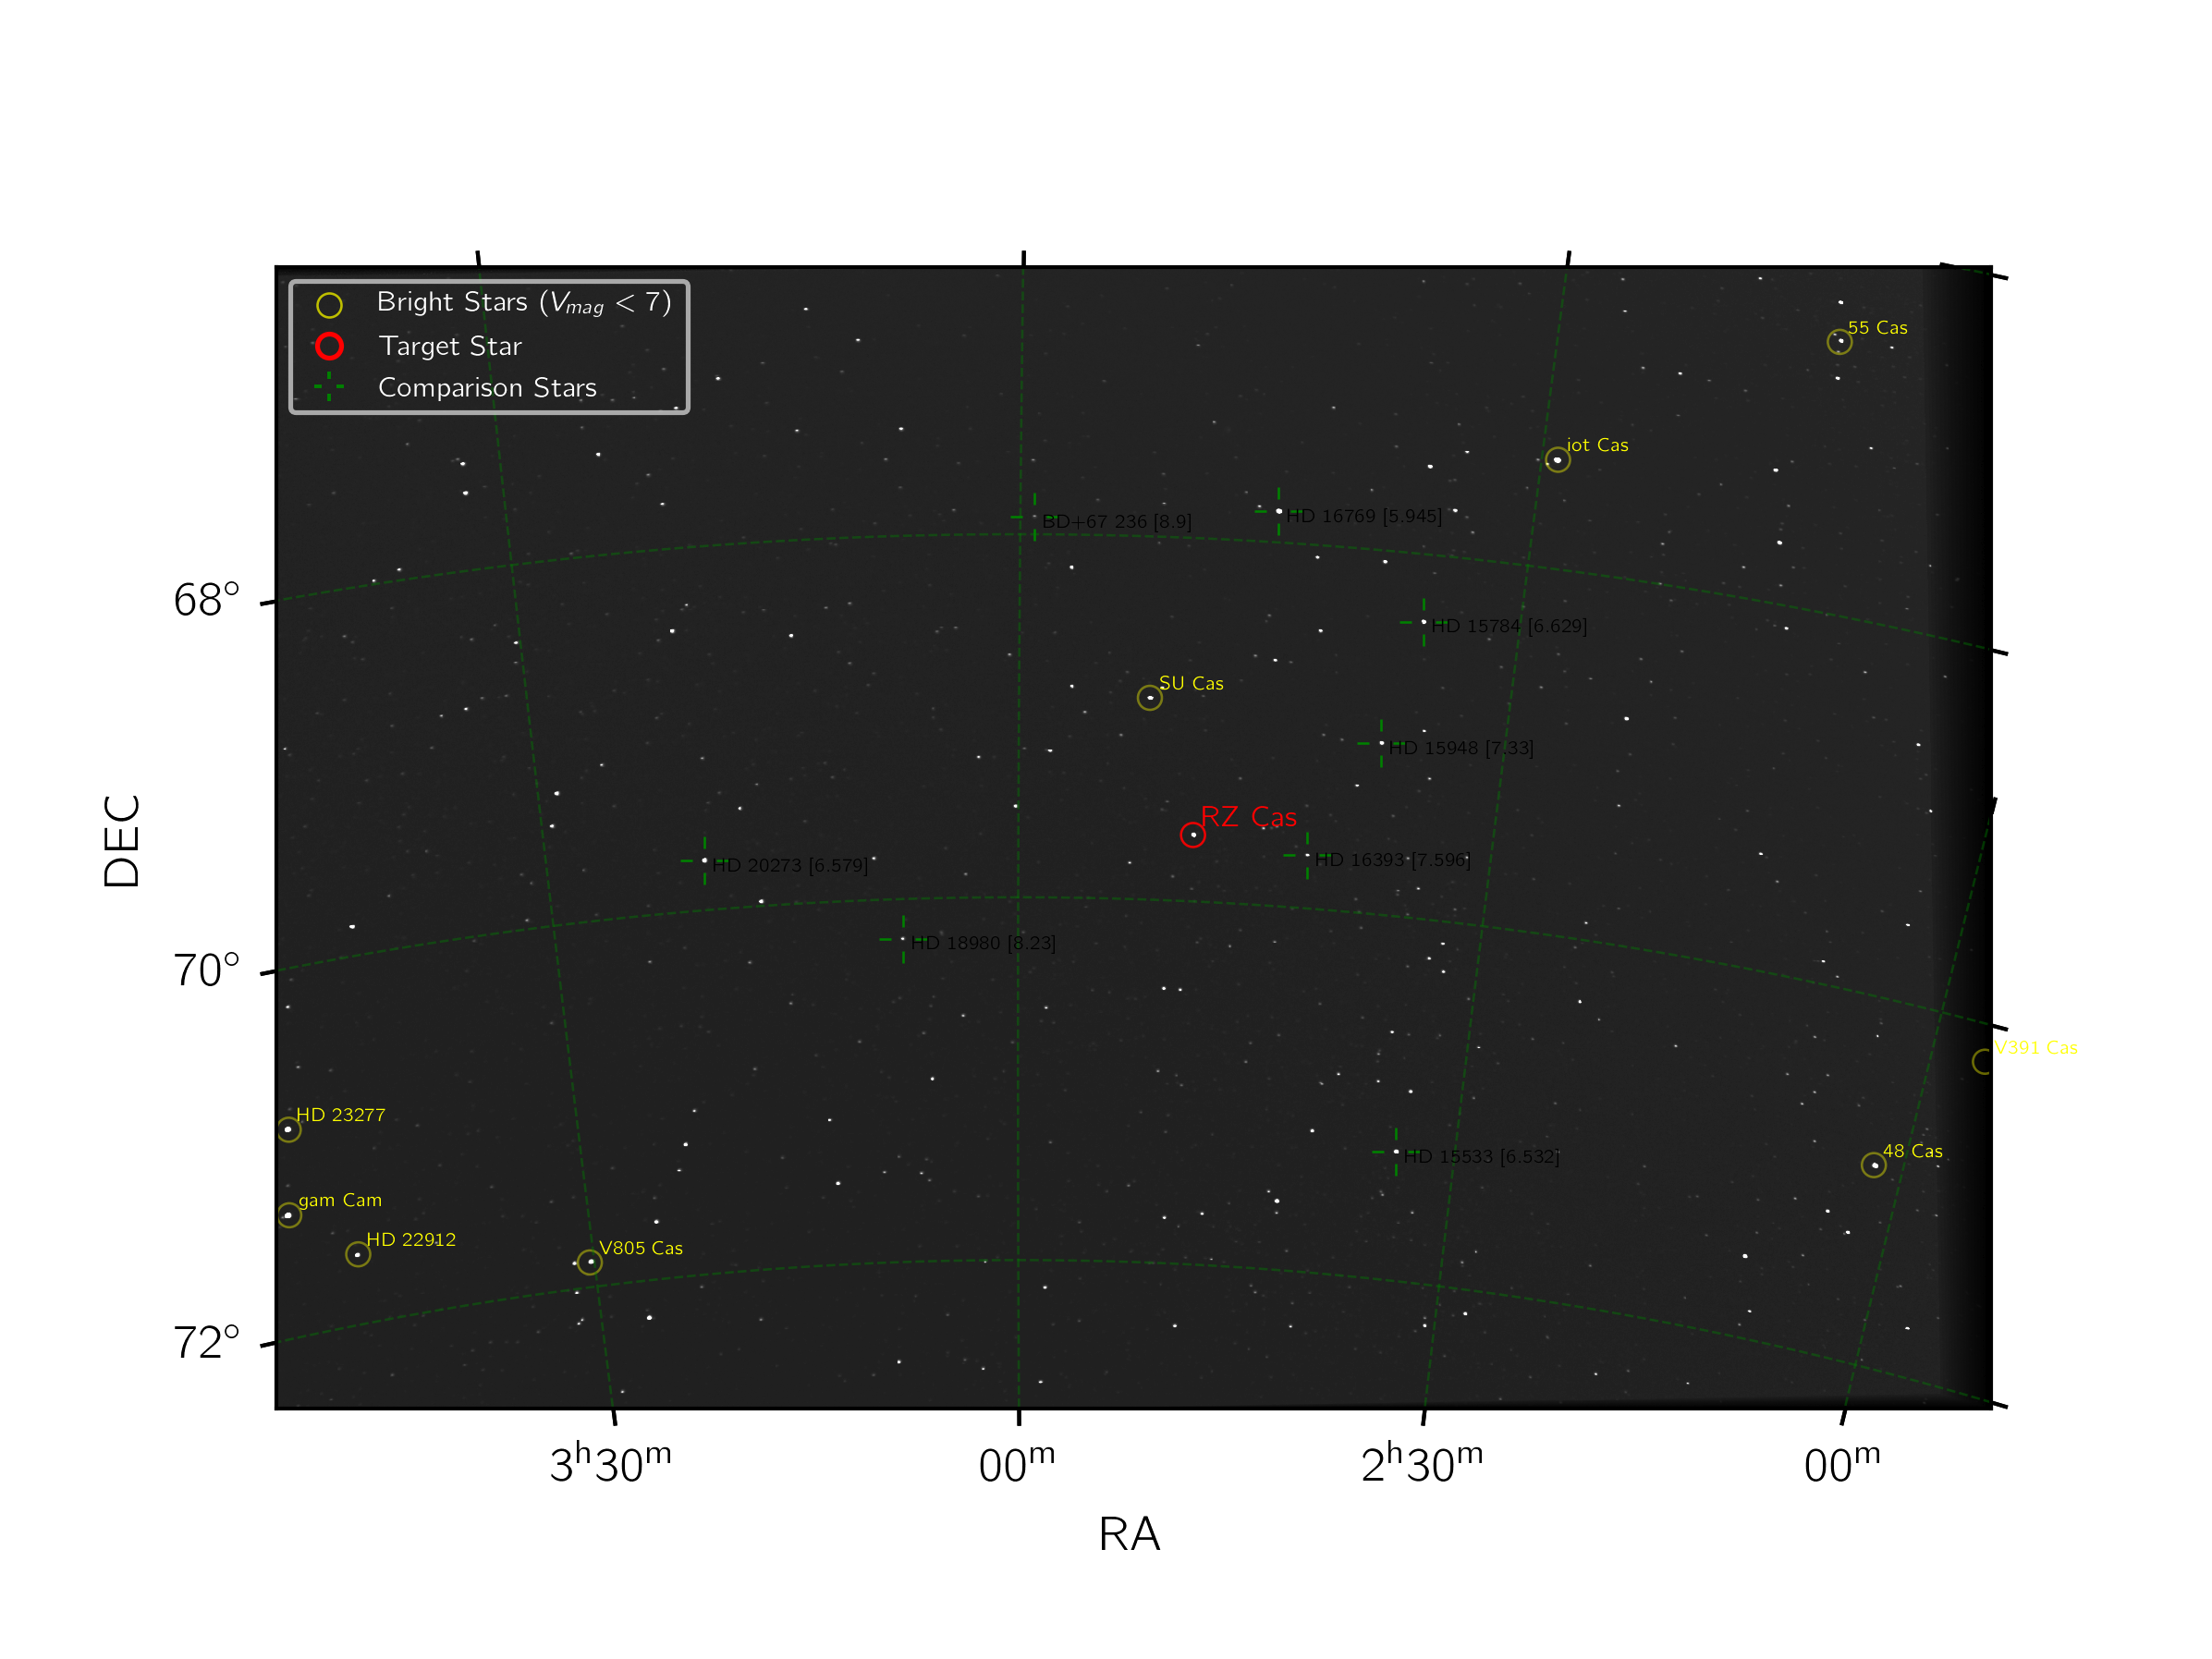

In [73]:
# Plot the WCS region


plt.figure(dpi=170)
ax = plt.subplot(projection=wcs)
#plt.grid(color='green', linestyle='dashed', lineweight=1)
ax.grid(which='major', axis='both', linestyle="--", linewidth=0.5, color='green', alpha=.4)
ax.imshow(hdu.data, vmin=0, vmax=800, origin='lower',cmap='gray',norm=norm)

# Display options
ax.set_xlabel('RA')
ax.set_ylabel('DEC')

for row in range(len(result)):
    if result['name'][row] == 'RZ Cas':
        ax.scatter(result['RA_d__ICRS__'][row], result['DEC_d__ICRS__'][row],
           transform=ax.get_transform('icrs'), s=25,
           edgecolor='red', facecolor='none', linewidths=.5,
              alpha=.9)
        ax.annotate(result['name'][row], 
                xy=(result['RA_d__ICRS__'][row],result['DEC_d__ICRS__'][row]),
                xycoords=ax.get_transform('icrs'),
                xytext=(10, 8), textcoords='offset pixels',
                color='red',size=6, fontweight='bold'
               # arrowprops=dict(arrowstyle='-', facecolor='white'),
            )
    elif result['name'][row] in ('iot Cas A', 'iot Cas B', '48 Cas A', '48 Cas B','HD 15533','HD 15784','HD 20273','HD 18980','HD 16393','HD 15948','BD+67 236','HD 16769'
):
        # Skip some binary system members and our comparison stars
        continue
    else:
        ax.scatter(result['RA_d__ICRS__'][row], result['DEC_d__ICRS__'][row],
           transform=ax.get_transform('icrs'), s=25,
           edgecolor='yellow', facecolor='none', linewidths=.5,
              alpha=.4)
        #ax.annotate(result['name'][row] + " [m{:.3f}]".format(result['FLUX_V'][row]), 
        ax.annotate(result['name'][row], 
                xy=(result['RA_d__ICRS__'][row],result['DEC_d__ICRS__'][row]),
                xycoords=ax.get_transform('icrs'),
                #xytext=(15, 12), textcoords='offset pixels',
                xytext=(10, 8), textcoords='offset pixels',
                color='yellow',size=4,
               # arrowprops=dict(arrowstyle='-', facecolor='white'),
            )

# Create custom crosshair marker for comparison stars
# https://matplotlib.org/3.2.1/gallery/shapes_and_collections/marker_path.html
#crosshair = mpath.Path([[0,0],[1,1],[1,0]],[1,2,2])
#crosshair = mpath.Path([[0,1],[0,2]],[[1,0],[1,1]],[1,2,2])
verts = [
   (0, 1),
   (0, 2),
   (1, 0),
   (2, 0),
   (0,-1),
   (0,-2),
   (-1, 0),
   (-2, 0)
]

codes = [
    mpath.Path.MOVETO,
    mpath.Path.LINETO,
    mpath.Path.MOVETO,
    mpath.Path.LINETO,
    mpath.Path.MOVETO,
    mpath.Path.LINETO,
    mpath.Path.MOVETO,
    mpath.Path.LINETO,
]

crosshair = mpath.Path(verts, codes)
        
# Plot differential photometry comparison stars
mag_apertures=[6.532,6.629,6.579,8.23,7.596,7.33,8.9,5.945]
dec_apertures=[71.28976389,68.37111111,69.72814167,70.218,69.70803333,69.05795278,67.90308333,67.82987202]
ra_apertures=[38.5022875,38.94107917,49.99757083,46.8750125,40.40090417,39.39627917,44.79842917,41.220026]
name_apertures=['HD 15533','HD 15784','HD 20273','HD 18980','HD 16393','HD 15948','BD+67 236','HD 16769']

for row in range(len(dec_apertures)):
    ax.scatter(ra_apertures[row], dec_apertures[row],
           transform=ax.get_transform('icrs'), marker=crosshair, s=100,
           edgecolor='green', facecolor='none', linewidths=.5,
              alpha=1, label='Comparison Star')
#    r'$\textcolor{blue}{e^{-x/5}} + \textcolor[rgb]{0.0, 0.5, 0.0}{e^{-x/1}}$', 
#    ax.annotate(r'$\textcolor{green}{name_apertures[row]}' + "\nm" + r'\textcolor{green}{:.3f}$'.format(mag_apertures[row]),

    #ax.annotate(r'\textcolor{green}{testgreen} ' + "\n" + 'blah \textcolor{red}{testred}',
    ax.annotate(r'\textcolor{yellow}{' + name_apertures[row] + r'} \textcolor{white}{[}\textcolor{green}{' + str(mag_apertures[row]) + r'}\textcolor{white}{]}',
                xy=(ra_apertures[row], dec_apertures[row]),
                xycoords=ax.get_transform('icrs'),
                xytext=(10, -12), textcoords='offset pixels', 
                #color='white',
                size=4,#multialignment='right',fontweight='heavy'
               # arrowprops=dict(arrowstyle='-', facecolor='white'),
            )

# Create manual legend
legend_elements = [Line2D([0], [0], marker='o', markersize=5, 
                          color='y', markeredgewidth=.5, markerfacecolor='none', 
                          lw=0, label=r'Bright Stars $({V_{mag} < 7})$'),
                   Line2D([0], [0], marker='o', markersize=5, 
                          color='r', markeredgewidth=1, markerfacecolor='none',
                          lw=0, label='Target Star'),
                   Line2D([0], [0], marker=crosshair, markersize=6, 
                          color='g', markeredgewidth=.75, markerfacecolor='none',
                          lw=0, label='Comparison Stars')]


# Create the figure
#fig, ax = plt.subplots()
#plt.legend(handles=legend_elements, loc='upper left')
legend = plt.legend(handles=legend_elements, loc='upper left',facecolor='none', fontsize='xx-small')
#ax.legend(handles=legend_elements, loc='upper left',facecolor='black', framealpha=1, fontcolor='white')
#legend = plt.legend()
plt.setp(legend.get_texts(), color='w')
    
#plt.legend()
# Plot export
#plt.savefig("RZCas_star_field.png", bbox_inches='tight', dpi=600)
plt.savefig("RZCas_star_field.pdf", bbox_inches='tight')

# PGF format for use with LaTeX
#plt.savefig("RZCas_star_field.pgf", bbox_inches='tight')
#plt.show()